Title: Do NBA teams with greater team salaries win more? 
Date: 2019-03-30 3:00
Tags: python
Slug: nba_team_salary

FiveThirtyEight is one of my favourite places to read thoughtful analysis, and see data visualizations. I was inspired by one of their posts on ['how your favourite baseball team blows its money'](https://fivethirtyeight.com/features/how-your-favorite-baseball-team-blows-its-money/). As an avid basketball fan, I recreated this graphic with NBA data. 

This was incredible practice with Matplotlib. Thank you to Amy Gordon for her [Github](https://github.com/ag2816/) for the style guide.

### Background

![nba svg](images/nba_team_salary_blog_40_0.svg)

This chart illustrates the relationship between team spending and win percentage for each basketball season from 2001 - 2015. Essentially, the steeper the curve, the better the team was maximizing value. 

* Each regular season is one dot in the figure
* Salaries are inflation adjusted, and standardized.
* The coloured line in each chart represents the linear regression fit for a team
* The grey line represents the linear regression fit for the league in aggregate

More money, more wins. There is a rough trend suggesting that higher team salaries lead to a greater winning percentage. This relationship is particularly strong for the Boston Celtics and Golden State Warriors.

On the other hand, this relationship is flat for others. For example, irrespective of team salary, the San Antonio Spurs is a winning organization. They are better at managing its roster and payroll versus others. They pride themselves with developing talent organically with scouting, coaching, and player development. Rather than overpaying Superstar players in the free agency market, they sign undervalued players (players who contribute more to win share, relatively their salary would suggest). This is similar to the thinking in MoneyBall, and has been widely studied in sports. Coupled with the fact that there is usually a salary cap limit in professional sports, this becomes a very interesting dynamic. 

Worst out of all the teams, New York Knicks tend to overpay players, which don't yield any marginal wins on the court and underperform relative to expectations.

---

#### Data

Game Data:
https://www.kaggle.com/fivethirtyeight/fivethirtyeight-nba-elo-dataset

Salary data (exported to CSV):
https://hoopshype.com/salaries/


For those interested, keep reading for data wrangling and snippets of code.
<br>

---
### 1. Load & prepare data


In [304]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.linear_model import LinearRegression

# plt.rcParams['figure.dpi'] = 50
# %config InlineBackend.figure_format = 'retina'
%config InlineBackend.figure_format = 'svg'

Salary data

In [13]:
raw=pd.read_csv('./data/nba_team_salary.csv')

In [14]:
# reorganize columns in chronological order
salary = pd.concat([raw["team"], raw[raw.columns[:0:-1]]], axis=1)

# change NaN to zero for no salary expansion teams: Charlotte 2003, 2004; New Orleans 2001, 2002
salary.fillna("$0", inplace=True)

# rename city to mascot name to merge later with games dataset
teams = {"team":["Hawks","Celtics","Nets","Hornets","Bulls","Cavaliers","Mavericks","Nuggets",
                 "Pistons","Warriors","Rockets","Pacers","Clippers","Lakers","Grizzlies","Heat",
                 "Bucks","Timberwolves","Pelicans","Knicks","Thunder","Magic","Sixers","Suns",
                 "Trailblazers","Kings","Spurs","Raptors","Jazz","Wizards"]}
           
salary = pd.concat([pd.DataFrame(teams),salary.iloc[:,1:16]],axis=1)

# transform wide to long data for plotting
# 450 columns: 30 teams x 15 years
long_salary = pd.melt(salary, id_vars='team', var_name='year', value_name='salary')
long_salary.head()

# year into int
long_salary["year"] = long_salary["year"].apply(lambda x: int(x))

# salary into int
long_salary["salary"] = long_salary["salary"].apply(lambda x: int(x.replace("$","").replace(",","")))

---
To make the data more comparable year over year, let's standardize the salaries. This function calculates how many standard deviations a team's salary is from the league average for a given year and returns that value. 

In [15]:
def z_salary(df,year,salary):
    year_mean = df[(df['year']==year)]['salary'].mean()
    year_std = df[(df['year']==year)]['salary'].std()
    return (salary - year_mean)/year_std

In [16]:
long_salary['z_salary'] = long_salary.apply(lambda row: z_salary(long_salary, row["year"], row["salary"]), axis=1)
long_salary.head()

,team,year,salary,z_salary
0,Hawks,2001,57438766,-0.689421
1,Celtics,2001,75244004,0.086161
2,Nets,2001,100821283,1.200288
3,Hornets,2001,67881439,-0.234546
4,Bulls,2001,43399261,-1.300970


In [17]:
# export to csv 
long_salary.to_csv("./data/nba_team_salary_final.csv")

---
Games data

From this NBA Elo dataset from Kaggle on FiveThirtyEight, I'll need to tally the following for each season. 
* G: Games play
* W: Games won
* L: Games lost

In the future, I'll be web scraping, which will make this easier. 

In [18]:
games = pd.read_csv('./data/nba_elo.csv')

# I'll only look at the regular season to keep n consistent across teams
games = games[games["is_playoffs"] == 0]

# This dataset has a lot of extraneous information, so I'll focus on the columns of interest. 
games = games[["year_id","date_game","team_id","fran_id","opp_id","opp_fran","game_result"]]

# This dataset is from 1947-2019, so I'll filter for years 2001 to 2015 to match our Salary data
games = games[(games["year_id"] >= 2001) & (games["year_id"] <= 2015)]

games.head()

,year_id,date_game,team_id,fran_id,opp_id,opp_fran,game_result
87750,2001,10/31/2000,ATL,Hawks,CHH,Pelicans,L
87751,2001,10/31/2000,CHH,Pelicans,ATL,Hawks,W
87752,2001,10/31/2000,CHI,Bulls,SAC,Kings,L
87753,2001,10/31/2000,SAC,Kings,CHI,Bulls,W
87754,2001,10/31/2000,DAL,Mavericks,MIL,Bucks,W


In [295]:
# reset record to beginning with list comphrension
record = {team:{"G":0,"W":0,"L":0} for team in teams}

In [20]:
# Each game shows up for the home and away team, so I'll only need to run control flow for when they lose
# Repeat for each year

def create_record(year):
    for i, row in games[games["year_id"]==year].iterrows():
        if row.game_result == "L":
            record[row.fran_id]["G"] += 1
            record[row.opp_fran]["G"] += 1
            record[row.fran_id]["L"] += 1
            record[row.opp_fran]["W"] += 1
    return record

In [21]:
# set up list of each team and each year
teams = sorted(list(games.fran_id.unique()))
all_years = list(games.year_id.unique())

In [23]:
# now repeat for all the years in a dictionary object
seasons = {}
for year in all_years:
    record = {team:{"G":0,"W":0,"L":0} for team in teams}
    seasons[year] = create_record(year)

In [296]:
create_record(2001)

{'Bucks': {'G': 82, 'W': 52, 'L': 30},
 'Bulls': {'G': 82, 'W': 15, 'L': 67},
 'Cavaliers': {'G': 82, 'W': 30, 'L': 52},
 'Celtics': {'G': 82, 'W': 36, 'L': 46},
 'Clippers': {'G': 82, 'W': 31, 'L': 51},
 'Grizzlies': {'G': 82, 'W': 23, 'L': 59},
 'Hawks': {'G': 82, 'W': 25, 'L': 57},
 'Heat': {'G': 82, 'W': 50, 'L': 32},
 'Hornets': {'G': 0, 'W': 0, 'L': 0},
 'Jazz': {'G': 82, 'W': 53, 'L': 29},
 'Kings': {'G': 82, 'W': 55, 'L': 27},
 'Knicks': {'G': 82, 'W': 48, 'L': 34},
 'Lakers': {'G': 82, 'W': 56, 'L': 26},
 'Magic': {'G': 82, 'W': 43, 'L': 39},
 'Mavericks': {'G': 82, 'W': 53, 'L': 29},
 'Nets': {'G': 82, 'W': 26, 'L': 56},
 'Nuggets': {'G': 82, 'W': 40, 'L': 42},
 'Pacers': {'G': 82, 'W': 41, 'L': 41},
 'Pelicans': {'G': 82, 'W': 46, 'L': 36},
 'Pistons': {'G': 82, 'W': 32, 'L': 50},
 'Raptors': {'G': 82, 'W': 47, 'L': 35},
 'Rockets': {'G': 82, 'W': 45, 'L': 37},
 'Sixers': {'G': 82, 'W': 56, 'L': 26},
 'Spurs': {'G': 82, 'W': 58, 'L': 24},
 'Suns': {'G': 82, 'W': 51, 'L': 31}

In [32]:
# rename index column to team
df_seasons = pd.DataFrame(seasons).reset_index().rename(columns={'index':'team'})

# wide to long data for plotting
long_seasons = pd.melt(df_seasons, id_vars='team', var_name='year', value_name='seasons')

# Break out the G,W,L into columns
items = list(long_seasons["seasons"])

long_seasons["G"] = pd.DataFrame([item["G"] for item in items])
long_seasons["L"] = pd.DataFrame([item["L"] for item in items])
long_seasons["W"] = pd.DataFrame([item["W"] for item in items])

# Calculate winning % for each team per year, and add as a new column
long_seasons['win_%'] = round(long_seasons['W']/long_seasons['G'],2)

# drop seasons, redundant column with G, L, W
long_seasons = long_seasons.drop(columns=['seasons'])

# make year into int so it can be merged later
long_seasons["year"] = long_seasons["year"].apply(lambda x: int(x))

In [33]:
long_seasons.head()

,team,year,G,L,W,win_%
0,Bucks,2001,82,30,52,0.63
1,Bulls,2001,82,67,15,0.18
2,Cavaliers,2001,82,52,30,0.37
3,Celtics,2001,82,46,36,0.44
4,Clippers,2001,82,51,31,0.38


Now, I'll merge the two datasets (long_salary, long_seasons) together into one dataframe for scatterplots

In [34]:
# merge datasets together
final = long_salary.merge(long_seasons, on=["team","year"])
final

# add divisions data
divisions_dict = {"Atlantic": ["Celtics","Nets","Sixers","Raptors","Knicks"],
             "Central": ["Bulls","Cavaliers","Pistons","Bucks","Pacers"],
             "Southeast": ["Hawks","Hornets","Heat","Magic","Wizards"],
             "Northwest": ["Timberwolves","Nuggets","Trailblazers","Thunder","Jazz"],
             "Pacific" : ["Warriors","Clippers","Lakers","Kings","Suns"],
             "Southwest" : ["Mavericks", "Rockets","Grizzlies","Pelicans","Spurs"]}

divisions = ["Atlantic","Central","Southeast","Northwest","Pacific","Southwest"]

def team_to_division(team):
    for division in divisions:
        if team in divisions_dict[division]:
            return division

final["division"] = final["team"].apply(lambda x: team_to_division(x))

# add conference data
conferences = ["East","West"]
conferences_dict = {"East": ["Celtics","Nets","Sixers","Raptors","Knicks","Bulls","Cavaliers","Pistons","Bucks","Pacers","Hawks","Hornets","Heat","Magic","Wizards"],
                   "West": ["Timberwolves","Nuggets","Trailblazers","Thunder","Jazz","Warriors","Clippers","Lakers","Kings","Suns","Mavericks", "Rockets","Grizzlies","Pelicans","Spurs"]}

def division_to_conference(division):
    for conference in conferences:
        if division in conferences_dict[conference]:
            return conference
        
final["conference"] = final["team"].apply(lambda x: division_to_conference(x))

In [35]:
# Remove early Charlotte Hornet years, missing data;
# they relocated to New Orleans, and were renamed as the Pelicans
final[final["team"] == 'Hornets'].loc[[3,33,63,93]]
final = final.drop([3,33,63,93])

In [36]:
final.to_csv("./data/final.csv")

---

### 2. Create plot for one team

* Use matplotlib, a Python 2D plotting library
* Create a scatterplot for the Raptors

In [37]:
raptors = final[final['team']== 'Raptors']

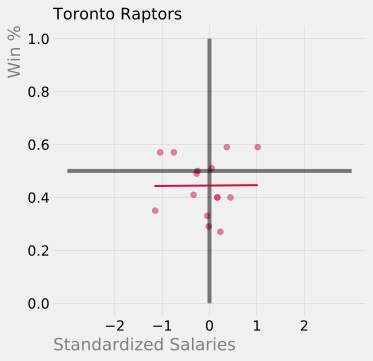

In [305]:
# change way we invoke plot so can manipulate the axis
fig, ax = plt.subplots(figsize=(5, 5))

#ax.scatter(x, y)
ax.scatter(x=raptors['z_salary'], y=raptors['win_%'],alpha=0.5,c="#CE1141")
plt.title('Toronto Raptors', position = (0,1), ha = 'left', fontsize=16)
plt.xlabel("Standardized Salaries", position = (0,0), ha = 'left', color = 'grey')
plt.ylabel('Win %', position = (0, 1), ha = 'right', color = 'grey')

# add linear regression line
X = pd.DataFrame(final[final["team"]=="Raptors"]["z_salary"])
Y = pd.DataFrame(raptors["win_%"])
linreg = linear_model.LinearRegression()
model = linreg.fit(X, Y)
predictions = model.predict(X)

plt.plot(X, predictions, color='#CE1141',linewidth=2)

# remove the top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# add in gridlines
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

# create cross hairs 
plt.hlines(0.5,-3, 3,alpha=0.5) 
plt.vlines(0,0,1,alpha=0.5)

# reduce ticks on x axis
plt.xticks([-2,-1,0,1,2])

plt.show()

Compare this with the plot for the league 

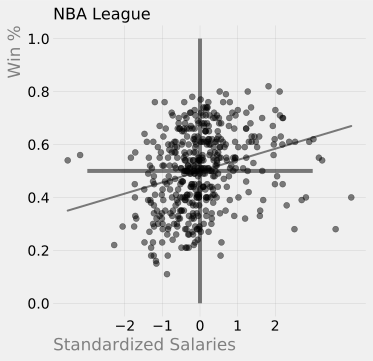

In [306]:
# change way we invoke plot so can manipulate the axis
fig, ax = plt.subplots(figsize=(5, 5))

#ax.scatter(x, y)
scatter_league = (ax.scatter(x=final['z_salary'], y=final['win_%'],alpha=0.5,c="#000000"),
                  plt.title('NBA League', position = (0,1), ha = 'left', fontsize=16),
                  plt.xlabel("Standardized Salaries", position = (0,0), ha = 'left', color = 'grey'),
                  plt.ylabel('Win %', position = (0, 1), ha = 'right', color = 'grey'))

# add linear regression line
X = pd.DataFrame(final["z_salary"])
Y_league = pd.DataFrame(final["win_%"])
linreg = linear_model.LinearRegression()
model = linreg.fit(X, Y_league)
predictions_league = model.predict(X)

# remove the top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# add in gridlines
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

# create cross hairs 
plt.hlines(0.5,-3, 3,alpha=0.5) 
plt.vlines(0,0,1,alpha=0.5)

# reduce ticks on x axis
plt.xticks([-2,-1,0,1,2])

league_plot = plt.plot(X, predictions_league, color='#000000',linewidth=2,alpha=0.5)
plt.show()

---
### 3. Generate plots for all the teams in a division, in a row

In [196]:
# Create a dictionary with the team names, and team plot colour. I'll do this with Atlantic, 
# then loop through each division on each row

atlantic = {"Celtics": "#007A33",
            "Nets": "#000000",
            "Sixers": "#006BB6",
            "Raptors": "#CE1141",
            "Knicks": "#F58426"}

In [287]:
def plot_team_row(team_df, ax,team_color='#00000'):

    # linear regression
    X = pd.DataFrame(team_df["z_salary"])
    Y = pd.DataFrame(team_df["win_%"])
    linreg = linear_model.LinearRegression()
    model = linreg.fit(X, Y)
    predictions = model.predict(X)
    ax.plot(X, predictions, color=team_color,alpha=0.8,linewidth=2)    
    
    # plot league average
    ax.plot(pd.DataFrame(final['z_salary']), predictions_league, color='#C4CED4',alpha=0.5,linewidth=2);

    # scatterplot
    ax.scatter(x=team_df['z_salary'], y=team_df['win_%'],alpha=0.5,c=team_color,s=10)
    
    # title for each team subplot
    ax.set_title(f"{team_df['team'].values[0]}",fontsize=10)
 
    # create cross hairs
    ax.hlines(0.5,-3, 3,alpha=0.5,linewidth=2)
    ax.vlines(0,.10,.90,alpha=0.5,linewidth=2)

    # ticks
    plt.xticks([-2,0,2])

    # remove borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # add in gridlines
    ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

* Outside of the loop, instantiate the plot with 1 row x 5 columns each of the teams in the division
* The `ax` object is an array with each array defining one subplot
* These arrays can be passed into to the previous `plot_team_row()` function

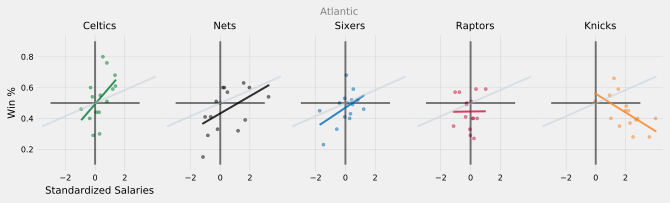

In [307]:
fig, ax = plt.subplots(nrows=1, ncols=5,figsize=(10,2.5),sharex=True, sharey=True)

# Division title
fig.suptitle('Atlantic', color = 'grey',fontsize=10) 

# Spacing for subplots
fig.subplots_adjust(hspace = 0.5, wspace=.001, top=0.825)

# pos determines which axes object to pass into the function
#there are 5 pos
col=0 
for team, colour in atlantic.items():
    plot_team_row(final[final['team']==team], ax[col],colour)
    col=col+1 
    
# force label to appear on first plot rather than the last plot
ax[0].set_xlabel('Standardized Salaries', fontsize=10)
ax[0].set_ylabel('Win %', fontsize=10)
ax[0].tick_params(labelsize=8)
ax[1].tick_params(labelsize=8)
ax[2].tick_params(labelsize=8)
ax[3].tick_params(labelsize=8)
ax[4].tick_params(labelsize=8)

plt.show()

---
### 4. Create the full chart for the entire NBA

In [198]:
# team colours source: https://teamcolorcodes.com/

atlantic = {"Celtics": "#007A33",
            "Nets": "#000000",
            "Sixers": "#006BB6",
            "Raptors": "#CE1141",
            "Knicks": "#F58426"}

central = {"Bulls": "#CE1141",
            "Cavaliers": "#6F263D",
            "Pistons": "#C8102E",
            "Bucks": "#00471B",
            "Pacers": "#FDBB30"}

southeast = {"Hawks": "#E03A3E",
             "Hornets":"#00788C",
             "Heat": "#98002E",
             "Magic": "#0077C0",
             "Wizards": "#002B5C"}

northwest = {"Timberwolves": "#236192",
            "Nuggets": "#FEC524",
            "Trailblazers": "#E03A3E",
            "Thunder": "#007AC1",
            "Jazz": "#00471B"}

pacific = {"Warriors": "#FDB927",
           "Lakers": "#552583",
           "Clippers": "#C8102E",
           "Kings": "#5A2D81",
           "Suns": "#E56020"}

    
southwest= {"Mavericks": "#00538C",
            "Rockets": "#CE1141",
            "Grizzlies": "#5D76A9",
            "Pelicans": "#85714D",
            "Spurs": "#C4CED4"}

nba_league = [atlantic, central, southeast, northwest, pacific, southwest]

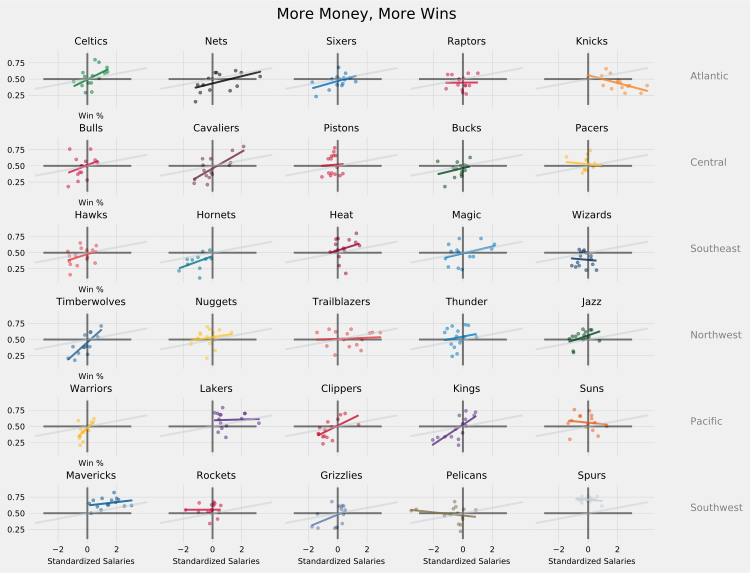

In [319]:
# 6 rows x 5 columns for all 30 teams
fig, ax = plt.subplots(nrows=6, ncols=5,figsize=(10,8),sharex=True, sharey=True)

# plot title
fig.suptitle('More Money, More Wins', x=0.55, y=1,color = 'black', fontsize=15) 

# Subplots spacing
fig.subplots_adjust(hspace = .5, wspace=.001, top=0.925)

# ax[count][pos]: the axes object contains a numpy array
# count indicates the row
# pos indicates the column
# loop through each division, each team
row = 0 
for division in nba_league:
    col=0 
    for team,color in division.items():
        plot_team_row(final[final['team']==team], ax[row][col],color)
        col=col+1
    row += 1
    
# labels
for i in list(range(0,5)):
    ax[5][i].set_xlabel('Standardized Salaries', fontsize=8)
    
for i in list(range(0,5)):
    ax[i][0].set_xlabel('Win %', fontsize=8)

# ticks
for i in list(range(0,5)):
    ax[5][i].tick_params(labelsize=8)

for i in list(range(0,5)):
    ax[i][0].tick_params(labelsize=8)

plt.figtext(1,0.875, "Atlantic", fontsize=10, color="grey")
plt.figtext(1,0.725, "Central", fontsize=10, color="grey")
plt.figtext(1,0.575, "Southeast", fontsize=10, color="grey")
plt.figtext(1,0.425, "Northwest", fontsize=10, color="grey")
plt.figtext(1,0.275, "Pacific", fontsize=10, color="grey")
plt.figtext(1,0.125, "Southwest", fontsize=10, color="grey") 
plt.show()

In [322]:
plt.savefig('nba_team_salary.pdf')

<Figure size 432x288 with 0 Axes>